PID Control Introduction
~~~~~~~~~~~~~~~~~~~~~~~~~~

In [598]:
# Library imports
import numpy as np
import random as rd
import matplotlib.pyplot as plt

seed = 2024
rd.seed(seed)
y_0 = rd.randrange(5000, 10000)
v_0 = rd.randrange(100, 250)

Controllers aim to control a process to keep some variable at a certain setpoint. A PID controller produces a control output by weighting three terms derived from how far the process is from the setpoint. The P stands for "proportional"; this term is the difference (error) between the currect process and the setpoint. The I stands for "integral"; this term is the accumulated error of the process over the entire time under control. The D stands for "derivative"; this term is the change in error.

Hear are some resources about Kalman filters. Skim over these for a brief introduction to the theory:

https://en.wikipedia.org/wiki/Proportional%E2%80%93integral%E2%80%93derivative_controller

https://www.ni.com/en/shop/labview/pid-theory-explained.html

We will consider a simplified version of our air brake control problem. Consider a point mass moving upwards with constant acceleration. Then, we get the following equations of motion:

    v(t) = v_0 + a_0*t
    y(t) = y_0 + v_0*t + a_0*t^2

We will assume that we have sensors to measure y--our barometers; however, we cannot measure v directly. Additonally, our barometer is 100% accurate and precise. We want to set the height to 15,000, but we control the system by adding velocity (deploying air brakes).

In [599]:
# ~~~~~~ Problem Setup ~~~~~~ 

# We include some randomness in the initialization to model uncertainty.
# You can set a seed to get the same randomness everytime. To do so, uncomment the next line:
# random.seed(2024)

# Class to model motion
class MotionState:
    # State Initialization
    def __init__(self, y_0, v_0, timestep, sensor_var):
        # Initial Conditions
        self.y_0 = y_0
        self.v_0 = v_0
        self.y = y_0
        self.v = v_0
        # System Computation Timestep
        self.timestep = timestep

    # State advance
    def advance_time(self):
        self.v = self.v + self.timestep*-10000
        self.y = self.y + self.timestep*self.v

    # Read the barometer
    def measure_y(self):
        return self.y

Next, we will setup our PID controller

In [600]:
# Class for PID controller
class PIDController:
    # Initialize constants
    def __init__(self, K_proportional, K_integral, K_derivative, timestep, setpoint):
        self.K_p = K_proportional
        self.K_i = K_integral
        self.K_d = K_derivative

        self.dt = timestep
        self.setpoint = setpoint

        self.current_error = 0
        self.integral = 0
        self.previous_error = 0

    # Control output
    def control(self, measured_value):
        # Calculate the proportional response
        self.current_error = self.setpoint - measured_value
        # Accumulate error
        self.integral = self.integral + self.current_error*self.dt
        # Calculate change in error
        derivative = (self.current_error - self.previous_error)/self.dt
        self.previous_error = self.current_error

        # Return control output
        return self.K_p*self.current_error + self.K_i*self.integral + self.K_d*derivative

Now, we will create an object in motion, and see how the PID controller does with controlling the state. When creating the controller, we have a choice of constants. We will first see what happens when these constants are chosen randomly. Then, we will systematically choose good constants.

In [601]:
# Create our rocket in motion
rocket = MotionState(y_0 = y_0, v_0 = v_0, timestep = 0.1, sensor_var = 0.1)

# Create our controller
pid = PIDController(K_proportional=rd.randrange(0, 10), K_integral=rd.randrange(0, 10), K_derivative=rd.randrange(0, 10), timestep=0.1, setpoint=7500)

We will see how the system fair over time.

In [602]:
# Initialize arrays to hold states
heights = []
array_size = 20

for i in range(array_size):
    # Read the barometer sensor
    y = rocket.measure_y()
    # Calculate controller output
    u = pid.control(y)
    
    # Adjust the system
    rocket.v = u
    # Advance time
    rocket.advance_time()

    # Fill arrays
    heights.append(y)
    

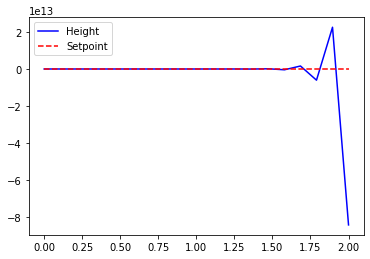

In [603]:
# Graph the system
times = np.linspace(start = 0.0, stop = array_size * rocket.timestep, num = array_size)
setpoints = np.empty(array_size)
setpoints.fill(pid.setpoint)

plt.plot(times, heights, color="blue", label="Height")
plt.plot(times, setpoints, label="Setpoint", color="red", linestyle = "dashed")
plt.legend()

plt.show()

You should see that the controller didn't work well (unless you got lucky with the random constants). Instead, we need to tune the constants of the controller.

We'll start by tuning the P constant leaving all others to be zero. This term corresponds to how quickly the controller reaches a steady state. A higher K_p value will result in more sensitivity. There will alsways be steady-state error, so the P controller will oscilate. Play around with the constant until the controller oscilates quickly enough the affect the height, but not so quickly that we can't recover.

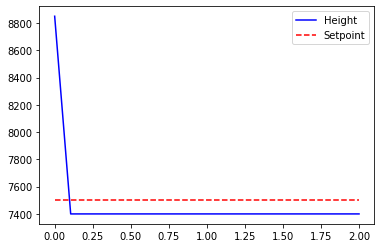

In [604]:
# Create our rocket in motion
rocket = MotionState(y_0 = y_0, v_0 = v_0, timestep = 0.1, sensor_var = 0.1)

# Create our controller
K_p = 10
pid = PIDController(K_proportional=K_p, K_integral=0, K_derivative=0, timestep=0.1, setpoint=7500)

# Initialize arrays to hold states
heights = []
array_size = 20

for i in range(array_size):
    # Read the barometer sensor
    y = rocket.measure_y()
    # Calculate controller output
    u = pid.control(y)
    
    # Adjust the system
    rocket.v = u
    # Advance time
    rocket.advance_time()

    # Fill arrays
    heights.append(y)

# Graph the system
times = np.linspace(start = 0.0, stop = array_size * rocket.timestep, num = array_size)
setpoints = np.empty(array_size)
setpoints.fill(pid.setpoint)

plt.plot(times, heights, color="blue", label="Height")
plt.plot(times, setpoints, label="Setpoint", color="red", linestyle = "dashed")
plt.legend()

plt.show()

Next, we'll add the integral term. This term corrects the steady-state error. Tweak this constant until the controllersettles quickly to the setpoint.

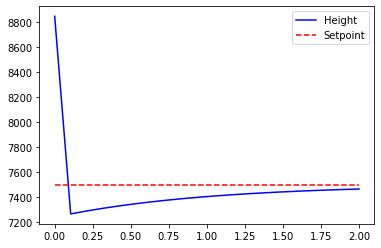

In [605]:
# Create our rocket in motion
rocket = MotionState(y_0 = y_0, v_0 = v_0, timestep = 0.1, sensor_var = 0.1)

# Create our controller
K_i = 10
pid = PIDController(K_proportional=K_p, K_integral=K_i, K_derivative=0, timestep=0.1, setpoint=7500)

# Initialize arrays to hold states
heights = []
array_size = 20

for i in range(array_size):
    # Read the barometer sensor
    y = rocket.measure_y()
    # Calculate controller output
    u = pid.control(y)
    
    # Adjust the system
    rocket.v = u
    # Advance time
    rocket.advance_time()

    # Fill arrays
    heights.append(y)

# Graph the system
times = np.linspace(start = 0.0, stop = array_size * rocket.timestep, num = array_size)
setpoints = np.empty(array_size)
setpoints.fill(pid.setpoint)

plt.plot(times, heights, color="blue", label="Height")
plt.plot(times, setpoints, label="Setpoint", color="red", linestyle = "dashed")
plt.legend()

plt.show()

Finally, we'll add the derivative term. This term predicts the future rate of change, and can result in a faster response but isn't also necessary. If the controller starts oscilating more, the K_d is too high.

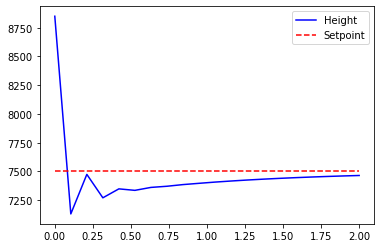

In [606]:
# Create our rocket in motion
rocket = MotionState(y_0 = y_0, v_0 = v_0, timestep = 0.1, sensor_var = 0.1)

# Create our controller
K_d = 0.1
pid = PIDController(K_proportional=K_p, K_integral=K_i, K_derivative=K_d, timestep=0.1, setpoint=7500)

# Initialize arrays to hold states
heights = []
array_size = 20

for i in range(array_size):
    # Read the barometer sensor
    y = rocket.measure_y()
    # Calculate controller output
    u = pid.control(y)
    
    # Adjust the system
    rocket.v = u
    # Advance time
    rocket.advance_time()

    # Fill arrays
    heights.append(y)

# Graph the system
times = np.linspace(start = 0.0, stop = array_size * rocket.timestep, num = array_size)
setpoints = np.empty(array_size)
setpoints.fill(pid.setpoint)

plt.plot(times, heights, color="blue", label="Height")
plt.plot(times, setpoints, label="Setpoint", color="red", linestyle = "dashed")
plt.legend()

plt.show()

These constants are tuned for the specifc set of initial conditions and setpoint. Try changing the initial conditions and setpoint. Does the controller still work well? Also try changing the model.